In [1]:
# ! pip install torch_geometric

In [2]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import DenseGCNConv, dense_diff_pool
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import sys

from torch_geometric.datasets import Entities, TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj


from utils import *
from model import *

In [3]:
# Load Dataset
# dataset = Entities(root='data/Entities', name='MUTAG')
# dataset = TUDataset(root='data/TUDataset', name='MUTAG')
dataset = TUDataset(root='data/TUDataset', name='Mutagenicity')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2

Data(edge_index=[2, 32], x=[16, 14], edge_attr=[32, 3], y=[1])
Number of nodes: 16
Number of edges: 32
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [4]:
torch.manual_seed(12345)

# Train test split
train_split = 0.8
batch_size = 16
train_loader, test_loader = prepare_data(dataset, train_split, batch_size)


Class split - Training 0: 1901 1: 1568, Test 0: 500 1: 368


In [5]:
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in loader:
        adj = to_dense_adj(data.edge_index, data.batch)
        batched_x = pad_features(data)
        
        optimizer.zero_grad()

        out, l, e = model(batched_x, adj)
        
        loss = criterion(out, data.y) + l + e
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

In [6]:
def test(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for data in loader:
            adj = to_dense_adj(data.edge_index, data.batch)
            batched_x = pad_features(data)
            out, _, _ = model(batched_x, adj, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)

In [7]:
model = DiffPoolGNN(dataset.num_features, dataset.num_classes)  

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

Epoch 1, Train Loss: 3.4360, Test Loss: 0.5982, Test Acc: 0.6705
Epoch 2, Train Loss: 3.3605, Test Loss: 0.5444, Test Acc: 0.7177
Epoch 3, Train Loss: 3.3472, Test Loss: 0.5720, Test Acc: 0.6809
Epoch 4, Train Loss: 3.3241, Test Loss: 0.5635, Test Acc: 0.7005
Epoch 5, Train Loss: 3.3071, Test Loss: 0.5411, Test Acc: 0.7385
Epoch 6, Train Loss: 3.2947, Test Loss: 0.5296, Test Acc: 0.7431
Epoch 7, Train Loss: 3.2931, Test Loss: 0.5276, Test Acc: 0.7327
Epoch 8, Train Loss: 3.2825, Test Loss: 0.5126, Test Acc: 0.7581
Epoch 9, Train Loss: 3.2745, Test Loss: 0.5111, Test Acc: 0.7535
Epoch 10, Train Loss: 3.2718, Test Loss: 0.5077, Test Acc: 0.7488
Epoch 11, Train Loss: 3.2644, Test Loss: 0.5176, Test Acc: 0.7558
Epoch 12, Train Loss: 3.2613, Test Loss: 0.5096, Test Acc: 0.7627
Epoch 13, Train Loss: 3.2586, Test Loss: 0.5047, Test Acc: 0.7535
Epoch 14, Train Loss: 3.2539, Test Loss: 0.4932, Test Acc: 0.7604
Epoch 15, Train Loss: 3.2493, Test Loss: 0.5148, Test Acc: 0.7546
Epoch 16, Train Los

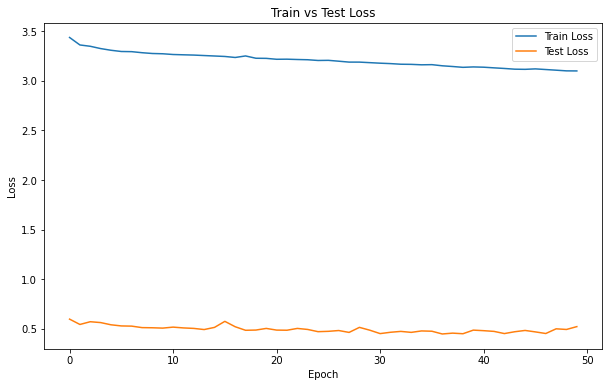

In [8]:
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    test_loss, test_acc = test(model, test_loader, criterion)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()